# Data & Package Import

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/비타민복프

/content/drive/MyDrive/비타민복프


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# 데이터 시각화 위한 패키지
!pip install plotly-geo
!pip install pyshp
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 435.8 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 23.1 MB/s eta 0:00:00


In [3]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 500)

import plotly.figure_factory as ff
import geopandas
import shapely
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit

In [7]:
# load dataset

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_census = pd.read_csv('census_starter.csv')

# feature engineering

- census dataset
  - pctbb[year] : 브로드밴드를 설치한 가구의 비율 / 나라별
  - pctcollege[year] - 4년제 대학 학위 가진 25세 이상 인구비율
  - pct_foreignborn[year] - US에서 태어나지 않은 인구비율
  - pct_itworkers[year] - 정보관련 산업에 종사하는 비율
  - median_hhinc[year] - 중위 가구 소득

In [8]:
# combine train and testset
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'
df = pd.concat((df_train, df_test)).sort_values('row_id').reset_index(drop=True)

In [9]:
# merge census data with train-test dataset. 
df_all = df.merge(df_census, on = 'cfips', how='left')

In [10]:
df_all['first_day_of_month'] = pd.to_datetime(df_all["first_day_of_month"])
df_all["year"] = df_all["first_day_of_month"].dt.year
df_all['month'] = df_all["first_day_of_month"].dt.month

In [12]:
# add 2-year lag census data to each rows 

conditions = [df_all['year']==2019,df_all['year']==2020,df_all['year']==2021, df_all['year']==2022, df_all['year']==2023]
choices_bb = [df_all['pct_bb_2017'],df_all['pct_bb_2018'],df_all['pct_bb_2019'],df_all['pct_bb_2020'],df_all['pct_bb_2021'] ]
choices_college = [df_all['pct_college_2017'],df_all['pct_college_2018'],df_all['pct_college_2019'],
                   df_all['pct_college_2020'],df_all['pct_college_2021']]
choices_foreign = [df_all['pct_foreign_born_2017'],df_all['pct_foreign_born_2018'],df_all['pct_foreign_born_2019'],
                   df_all['pct_foreign_born_2020'],df_all['pct_foreign_born_2021']]
choices_workers = [df_all['pct_it_workers_2017'],df_all['pct_it_workers_2018'],df_all['pct_it_workers_2019'],
                   df_all['pct_it_workers_2020'],df_all['pct_it_workers_2021']]
choices_inc = [df_all['median_hh_inc_2017'],df_all['median_hh_inc_2018'],df_all['median_hh_inc_2019'],
               df_all['median_hh_inc_2020'],df_all['median_hh_inc_2021']]

In [13]:
df_all['year'].value_counts()
#2019 2020 2021 2022 2023<target>

2020    37620
2021    37620
2022    37620
2023    18810
2019    15675
Name: year, dtype: int64

In [16]:
df_all.info()
# year 2019 2020 2021 2022 2023 
# pct_bb 2017 2018 2019 2020 2021
# pct_college 2017 2018 2019 2020 2021
# pct_foreign_born 2017 2018 2019 2020 2021

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147345 entries, 0 to 147344
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 147345 non-null  object        
 1   cfips                  147345 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     147345 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  float64       
 7   dataset                147345 non-null  object        
 8   pct_bb_2017            147345 non-null  float64       
 9   pct_bb_2018            147345 non-null  float64       
 10  pct_bb_2019            147345 non-null  float64       
 11  pct_bb_2020            147345 non-null  float64       
 12  pct_bb_2021            147345 non-null  floa

In [17]:
df_all['pct_bb_2017']

0         80.8
1         80.8
2         80.8
3         80.8
4         80.8
          ... 
147340    78.7
147341    78.7
147342    78.7
147343    78.7
147344    78.7
Name: pct_bb_2017, Length: 147345, dtype: float64

In [18]:
df_all["pct_bb"] = np.select(conditions, choices_bb, default=np.nan)
# pct_bb, pct_college, pct_foregin, pct_workers, pct_inc : 2017 -> year : 2019
df_all["pct_college"] = np.select(conditions, choices_college, default=np.nan)
df_all["pct_foreign"] = np.select(conditions, choices_foreign, default=np.nan)
df_all["pct_workers"] = np.select(conditions, choices_workers, default=np.nan)
df_all["pct_inc"] = np.select(conditions, choices_inc, default=np.nan)

In [19]:
df_all['pct_bb']

0         80.8
1         80.8
2         80.8
3         80.8
4         80.8
          ... 
147340    87.1
147341    87.1
147342    87.1
147343    87.1
147344    87.1
Name: pct_bb, Length: 147345, dtype: float64

In [20]:
df_all['first_day_of_month']

0        2019-08-01
1        2019-09-01
2        2019-10-01
3        2019-11-01
4        2019-12-01
            ...    
147340   2023-02-01
147341   2023-03-01
147342   2023-04-01
147343   2023-05-01
147344   2023-06-01
Name: first_day_of_month, Length: 147345, dtype: datetime64[ns]

In [21]:
# drop unnecessary columns
df_all.drop(['pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'], axis=1, inplace=True)

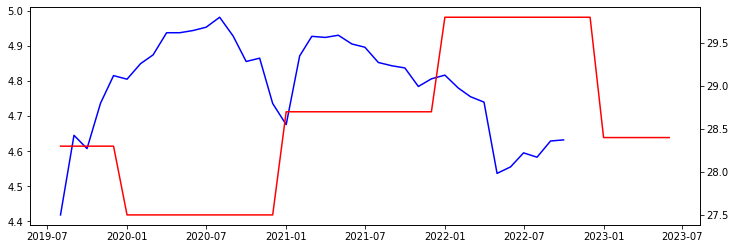

In [22]:
# let's see how '(2year-lag)pct_college' is related with micro-biz density
import matplotlib.pyplot as plt

test = df_all.set_index('first_day_of_month')
test = test[test['cfips']==56001]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['pct_college'], color='red' , label='college')

- pct_college 피쳐(year-2)와 density 피쳐(year) 간의 상관관계 확인 : 뚜렷하지 않음

In [23]:
train_pivoted = df_all.pivot(index='cfips',columns='first_day_of_month',values='microbusiness_density')

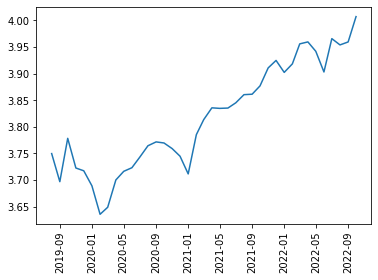

In [24]:
# micro-business density 
plt.plot(train_pivoted.mean(axis=0));
plt.xticks(rotation=90);

## create function for MA & EMA

- density 의 경우에는 점점 성장하는 추세
- 2020년 감소의 경우 코로나의 영향이 존재했을 가능성

In [25]:
# create function for MA and EMA
#SMA and EMA are both commonly-used trend indicators. SMA gives equal weight to all data points,  while EMA applies more weight to recent data points. 

def moving_average(df,i, n):
    MA = pd.Series(df[i].rolling(n, min_periods=n).mean(), name = 'MA_' + str(n))
    df = df.join(MA)
    return df

def weighted_moving_average(df,i, n):
    EMA = pd.Series(df[i].ewm(span=n, adjust=False, min_periods=n).mean(), name = 'EMA_' + str(n))
    df = df.join(EMA)
    return df

- MA : 이동 평균 모델 : 과거의 오차가 현재에 영향
- 말그대로 이동값의 평균값

In [26]:
# generate time-series based variables.
# create Moving Average variable.
df_all = moving_average(df_all, 'microbusiness_density', 3)
df_all = moving_average(df_all, 'microbusiness_density', 6)

# actually it's Exponential Moving Average. 
df_all = weighted_moving_average(df_all, 'microbusiness_density', 3)
df_all = weighted_moving_average(df_all, 'microbusiness_density', 6)

In [27]:
# add 'pct_change_before' variable. This variable shows that how the density changed previous month.
df_all['pct_change_before'] = df_all['microbusiness_density'].pct_change().shift(1) 

## generate lagged data 

- 과거에 대한 현재의 밀도 변화율 피쳐 생성
- lag1 means previous (one-month) month's mciro-biz density.

In [28]:
# generate lag date

def lag_feature(df):
    for lag in range(1, 6):
        df[f'lag_density_{lag}'] = df.groupby('cfips')['microbusiness_density'].shift(lag)
        df[f'lag_density_{lag}'] = df.groupby('cfips')[f'lag_density_{lag}'].bfill()
        
    return df
    
df_all = lag_feature(df_all)

- 왜 lag의 range를 1~6 으로 한거지?

In [38]:
# the average microbusiness density in each state by month
# each month's national average microbusines_density 
# national_avg : 월별 밀도 평균
# state_avg : 주의 월별 밀도 평균
df_all['national_avg'] = df_all.groupby(['year','month'])['microbusiness_density'].transform('mean')
df_all['state_avg'] = df_all.groupby(['state','year','month'])['microbusiness_density'].transform('mean')

In [30]:
# example 
df_all[df_all['cfips']==47081].head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,dataset,year,month,pct_bb,pct_college,pct_foreign,pct_workers,pct_inc,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_density_1,lag_density_2,lag_density_3,lag_density_4,lag_density_5,national_avg,state_avg
106173,47081_2019-08-01,47081,Hickman County,Tennessee,2019-08-01,2.675777,513.0,train,2019,8,53.7,7.0,0.9,2.0,39333.0,NaN,NaN,2.674302,2.620634,0.000000,2.675777,2.675777,2.675777,2.675777,2.675777,3.749621,3.180018
106174,47081_2019-09-01,47081,Hickman County,Tennessee,2019-09-01,2.607970,500.0,train,2019,9,53.7,7.0,0.9,2.0,39333.0,NaN,NaN,2.641136,2.617016,0.168225,2.675777,2.675777,2.675777,2.675777,2.675777,3.696846,3.208617
106175,47081_2019-10-01,47081,Hickman County,Tennessee,2019-10-01,2.733153,524.0,train,2019,10,53.7,7.0,0.9,2.0,39333.0,2.672300,NaN,2.687144,2.650198,-0.025341,2.607970,2.675777,2.675777,2.675777,2.675777,3.778263,3.207843
106176,47081_2019-11-01,47081,Hickman County,Tennessee,2019-11-01,2.738368,525.0,train,2019,11,53.7,7.0,0.9,2.0,39333.0,2.693164,NaN,2.712756,2.675389,0.048000,2.733153,2.607970,2.675777,2.675777,2.675777,3.722510,3.231535
106177,47081_2019-12-01,47081,Hickman County,Tennessee,2019-12-01,2.701857,518.0,train,2019,12,53.7,7.0,0.9,2.0,39333.0,2.724459,NaN,2.707307,2.682951,0.001908,2.738368,2.733153,2.607970,2.675777,2.675777,3.717284,3.230364
106178,47081_2020-01-01,47081,Hickman County,Tennessee,2020-01-01,2.660593,514.0,train,2020,1,57.3,7.4,1.2,1.6,41998.0,2.700273,2.686286,2.683950,2.676563,-0.013333,2.701857,2.738368,2.733153,2.607970,2.675777,3.689041,3.188005
106179,47081_2020-02-01,47081,Hickman County,Tennessee,2020-02-01,2.645064,511.0,train,2020,2,57.3,7.4,1.2,1.6,41998.0,2.669172,2.681168,2.664507,2.667564,-0.015272,2.660593,2.701857,2.738368,2.733153,2.607970,3.635546,3.156313
106180,47081_2020-03-01,47081,Hickman County,Tennessee,2020-03-01,2.588126,500.0,train,2020,3,57.3,7.4,1.2,1.6,41998.0,2.631261,2.677860,2.626316,2.644867,-0.005837,2.645064,2.660593,2.701857,2.738368,2.733153,3.648742,3.148403
106181,47081_2020-04-01,47081,Hickman County,Tennessee,2020-04-01,2.629536,508.0,train,2020,4,57.3,7.4,1.2,1.6,41998.0,2.620909,2.660591,2.627926,2.640487,-0.021526,2.588126,2.645064,2.660593,2.701857,2.738368,3.700048,3.191876
106182,47081_2020-05-01,47081,Hickman County,Tennessee,2020-05-01,2.634712,509.0,train,2020,5,57.3,7.4,1.2,1.6,41998.0,2.617458,2.643315,2.631319,2.638837,0.016000,2.629536,2.588126,2.645064,2.660593,2.701857,3.716288,3.208087


## create target variable

In [31]:
df_all['target'] = df_all.groupby('cfips')['microbusiness_density'].shift(-1)

- shift(-1) 하면 한 칸 씩 앞으로 올라가는 거 -> 미래의 값을 예측해야 하니까!

## create function to check the table at a glance

In [33]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [34]:
summary_table = summary(df_all)

data shape: (147345, 28)


In [35]:
# now you can check all variables at a glance.
summary_table

,data type,#missing,%missing,#unique,min,max,first value,second value,third value
row_id,object,0,0.000000,147345,NaN,NaN,10001_2019-08-01,10001_2019-09-01,10001_2019-10-01
cfips,int64,0,0.000000,3135,1001.0,56045.0,10001,10001,10001
county,object,2508000,0.170213,1871,NaN,NaN,Kent County,Kent County,Kent County
state,object,2508000,0.170213,51,NaN,NaN,Delaware,Delaware,Delaware
first_day_of_month,datetime64[ns],0,0.000000,47,NaN,NaN,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00
microbusiness_density,float64,2508000,0.170213,97122,0.0,284.34003,4.995701,5.031902,5.09827
active,float64,2508000,0.170213,19193,0.0,1167744.0,6624.0,6672.0,6760.0
dataset,object,0,0.000000,2,NaN,NaN,train,train,train
year,int64,0,0.000000,5,2019.0,2023.0,2019,2019,2019
month,int64,0,0.000000,12,1.0,12.0,8,9,10


# Modeling

In [37]:
# check columns
df_all.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'dataset', 'year', 'month', 'pct_bb',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'pct_change_before', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'national_avg',
       'state_avg', 'target'],
      dtype='object')

## let's choose one county as a sample and build a prediction model

In [41]:
# choose one county 
sample = df_all[df_all['cfips']==9011]

In [42]:
# choose train data only
sample_train = sample[sample['dataset']=='train']

In [43]:
### split train X and Y
train_X = sample_train[['year', 'month', 'pct_bb',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'pct_change_before',
       'national_avg', 'state_avg']]
train_y = sample_train['target']

In [44]:
# fill na with 'bfill'
train_X.fillna(method='bfill', inplace=True)

## Time Series Split

### overview

In [45]:
# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
from matplotlib.patches import Patch
cmap_cv = plt.cm.seismic
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
#     yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

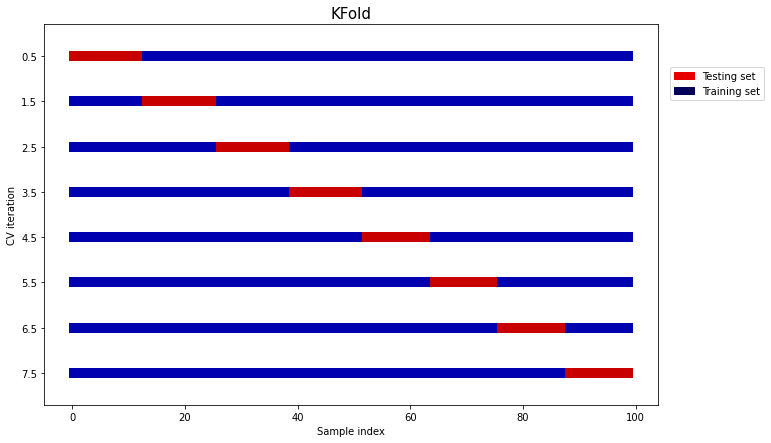

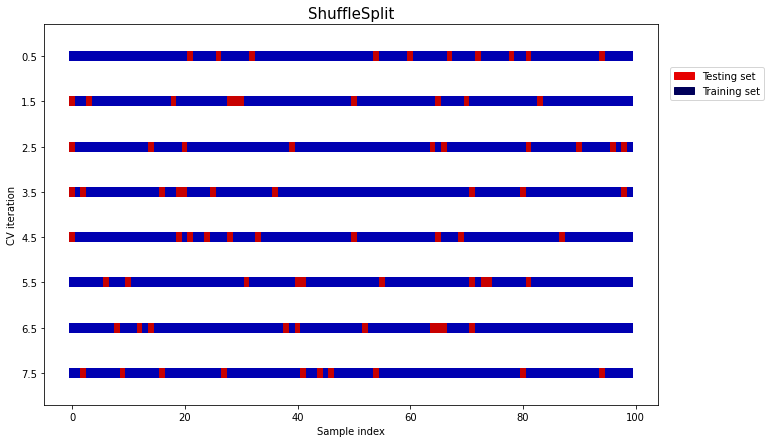

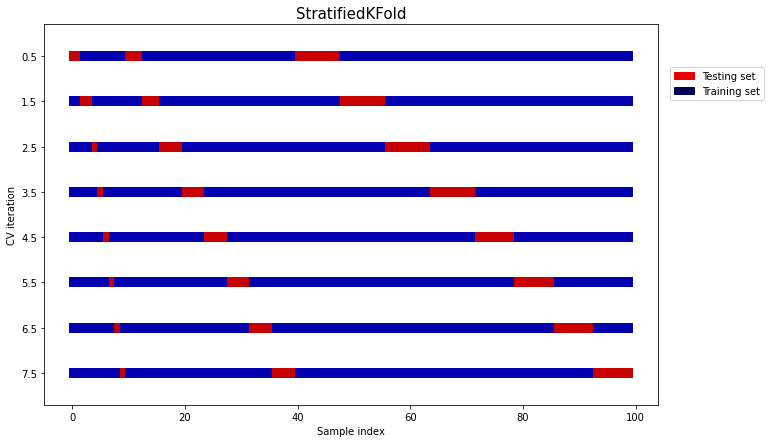

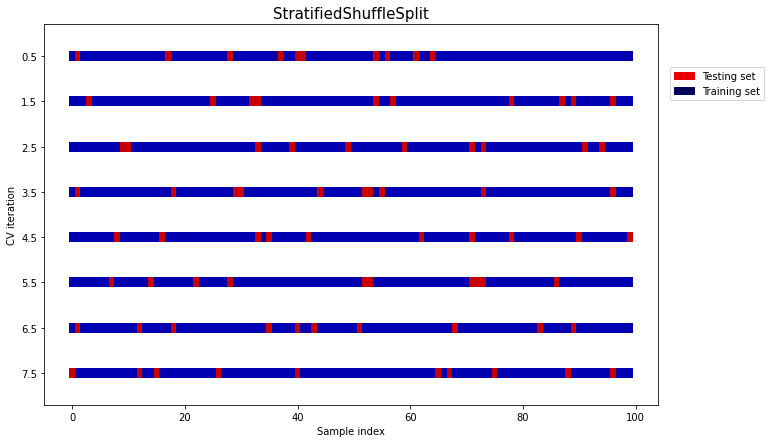

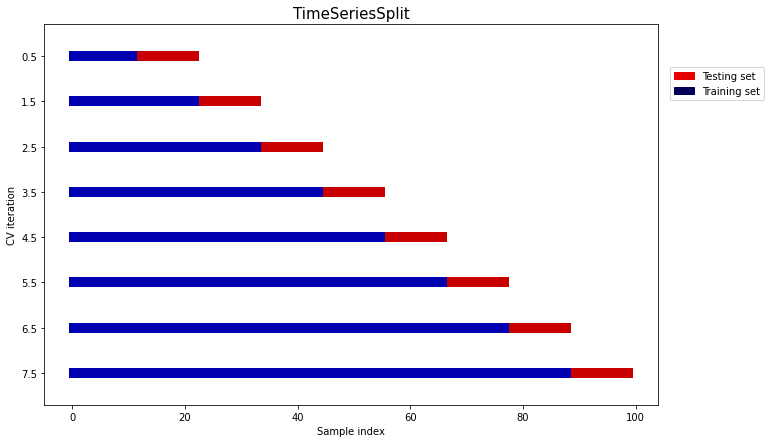

In [46]:
# time series split 
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit]
n_points = 100
n_splits = 8
X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

for i, cv in enumerate(cvs):
    this_cv = cv(n_splits=n_splits)
    plot_cv_indices(this_cv, n_splits, X, y, date_col=None)

- TimeSereisSplit 사용 안하는 것 : 미래 데이터 치팅 하는 거
- data leakage 방지 위해서 TimeSeriesSplit 사용한다

In [47]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 7
tscv = TimeSeriesSplit(n_splits)

Fold: 0
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10] 
 TEST indices: [11 12 13 14]


Fold: 1
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
 TEST indices: [15 16 17 18]


Fold: 2
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
 TEST indices: [19 20 21 22]


Fold: 3
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] 
 TEST indices: [23 24 25 26]


Fold: 4
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] 
 TEST indices: [27 28 29 30]


Fold: 5
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] 
 TEST indices: [31 32 33 34]


Fold: 6
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] 
 TEST indices: [35 36 37 38]




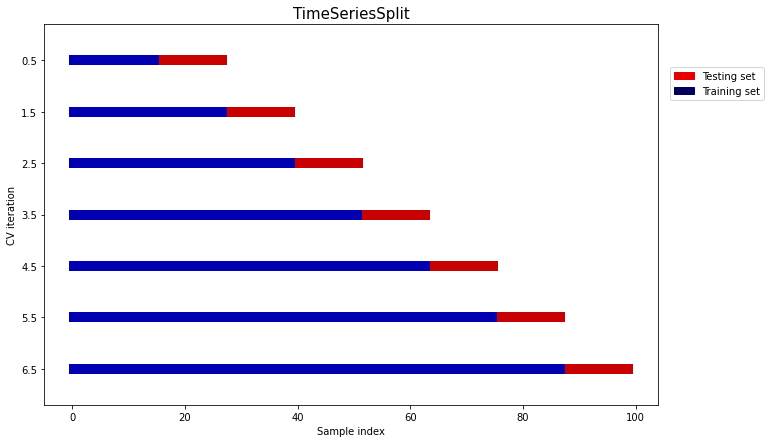

In [48]:
# In our case, data point is 39, so it would be splited like below
# (example taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py )

for fold, (train_index, test_index) in enumerate(tscv.split(sample[sample['dataset']=='train'])):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]


plot_cv_indices(tscv,n_splits, X, y)

## create evaluation metrics

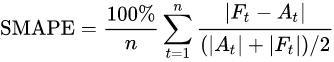

In [49]:
# create custom function
def SMAPE(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [50]:
def smape_cv(model):
    tscv = TimeSeriesSplit(n_splits=7)
    smape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), 
                                             desc=f'{model_name} Cross Validations', total=7):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        smape = SMAPE(y_test, pred) 
        smape_list.append(smape)
    return model_name, smape_list

def print_smape_score(model):
    # print cv and save the average
    model_name, score = smape_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} smape: {r:.4f}')
    print(f'\n{model_name} mean smape: {np.mean(score):.4f}')
    print('='*30)
    return model_name, np.mean(score)

In [51]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Elastic = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
RF = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=5, min_samples_split=2,
                           min_samples_leaf=2, random_state=1, n_jobs=-1)
XGB = xgb.XGBRegressor(n_estimators=500, max_depth=5, min_child_weight=5, gamma=0.1, n_jobs=-1)
LGBM = lgb.LGBMRegressor(n_estimators=500, max_depth=5, min_child_weight=5, n_jobs=-1)

In [52]:
models = []
scores = []
for model in [reg, ridge, lasso, Elastic, RF, XGB, LGBM]:
    model_name, mean_score = print_smape_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 107.57it/s]


1 FOLDS: LinearRegression smape: 1.2200
2 FOLDS: LinearRegression smape: 1.7158
3 FOLDS: LinearRegression smape: 1.4751
4 FOLDS: LinearRegression smape: 1.9872
5 FOLDS: LinearRegression smape: 0.7900
6 FOLDS: LinearRegression smape: 1.0151
7 FOLDS: LinearRegression smape: 0.4265

LinearRegression mean smape: 1.2328


Ridge Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 174.21it/s]


1 FOLDS: Ridge smape: 0.3649
2 FOLDS: Ridge smape: 1.6606
3 FOLDS: Ridge smape: 0.5027
4 FOLDS: Ridge smape: 0.3541
5 FOLDS: Ridge smape: 0.4077
6 FOLDS: Ridge smape: 0.7200
7 FOLDS: Ridge smape: 0.2355

Ridge mean smape: 0.6065


Lasso Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 155.66it/s]


1 FOLDS: Lasso smape: 0.4381
2 FOLDS: Lasso smape: 1.5152
3 FOLDS: Lasso smape: 0.3675
4 FOLDS: Lasso smape: 0.2912
5 FOLDS: Lasso smape: 0.3291
6 FOLDS: Lasso smape: 0.6997
7 FOLDS: Lasso smape: 0.2902

Lasso mean smape: 0.5616


ElasticNet Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 116.20it/s]


1 FOLDS: ElasticNet smape: 0.3655
2 FOLDS: ElasticNet smape: 1.6815
3 FOLDS: ElasticNet smape: 0.4669
4 FOLDS: ElasticNet smape: 0.3437
5 FOLDS: ElasticNet smape: 0.3771
6 FOLDS: ElasticNet smape: 0.7000
7 FOLDS: ElasticNet smape: 0.2279

ElasticNet mean smape: 0.5947


RandomForestRegressor Cross Validations: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


1 FOLDS: RandomForestRegressor smape: 2.5626
2 FOLDS: RandomForestRegressor smape: 0.8338
3 FOLDS: RandomForestRegressor smape: 0.3222
4 FOLDS: RandomForestRegressor smape: 1.0865
5 FOLDS: RandomForestRegressor smape: 1.0465
6 FOLDS: RandomForestRegressor smape: 0.8154
7 FOLDS: RandomForestRegressor smape: 1.1145

RandomForestRegressor mean smape: 1.1116


XGBRegressor Cross Validations:  14%|█▍        | 1/7 [00:00<00:00,  6.36it/s]

[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations:  71%|███████▏  | 5/7 [00:00<00:00, 15.58it/s]

[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 14.33it/s]


[14:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor smape: 2.7363
2 FOLDS: XGBRegressor smape: 1.1781
3 FOLDS: XGBRegressor smape: 2.0824
4 FOLDS: XGBRegressor smape: 2.7210
5 FOLDS: XGBRegressor smape: 3.2468
6 FOLDS: XGBRegressor smape: 3.0323
7 FOLDS: XGBRegressor smape: 2.6814

XGBRegressor mean smape: 2.5255


LGBMRegressor Cross Validations: 100%|██████████| 7/7 [00:00<00:00, 42.71it/s]

1 FOLDS: LGBMRegressor smape: 2.7382
2 FOLDS: LGBMRegressor smape: 1.1800
3 FOLDS: LGBMRegressor smape: 2.0843
4 FOLDS: LGBMRegressor smape: 2.7230
5 FOLDS: LGBMRegressor smape: 3.3584
6 FOLDS: LGBMRegressor smape: 3.3670
7 FOLDS: LGBMRegressor smape: 3.2984

LGBMRegressor mean smape: 2.6785
